# Importation des données

In [2]:
import pickle

with open('.\\data\\prepared_data\\useful\\X_useful_train.pkl', 'rb') as f:
    X_useful_train = pickle.load(f)
    
with open('.\\data\\prepared_data\\useful\\Y_useful_train.pkl', 'rb') as f:
    Y_useful_train = pickle.load(f)

type(X_useful_train)
type(Y_useful_train)
X_useful_train.info()
Y_useful_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3528 entries, 3465 to 1125
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PCA0    3528 non-null   float64
 1   PCA1    3528 non-null   float64
 2   PCA2    3528 non-null   float64
 3   PCA3    3528 non-null   float64
 4   PCA4    3528 non-null   float64
 5   PCA5    3528 non-null   float64
 6   PCA6    3528 non-null   float64
 7   PCA7    3528 non-null   float64
 8   PCA8    3528 non-null   float64
 9   PCA9    3528 non-null   float64
 10  PCA10   3528 non-null   float64
 11  PCA11   3528 non-null   float64
 12  PCA12   3528 non-null   float64
 13  PCA13   3528 non-null   float64
 14  PCA14   3528 non-null   float64
dtypes: float64(15)
memory usage: 441.0 KB
<class 'pandas.core.series.Series'>
Int64Index: 3528 entries, 3465 to 1125
Series name: Attrition
Non-Null Count  Dtype 
--------------  ----- 
3528 non-null   object
dtypes: object(1)
memory usage: 55.1+ KB


# Entrainement des modèles

In [3]:
from sklearn.preprocessing import LabelEncoder

# Instantiate label encoder
label_encoder = LabelEncoder()

# Fit and transform y_train
y_train_useful_encoded = label_encoder.fit_transform(Y_useful_train)

0.0

In [ ]:
### Arbre de décision
from sklearn.tree import DecisionTreeClassifier
import numpy as np

tree_class = DecisionTreeClassifier(random_state=42)
tree_class.fit(X_useful_train, y_train_useful_encoded)
from sklearn.metrics import mean_squared_error

useful_predictions = tree_class.predict(X_useful_train)
tree_mse = mean_squared_error(y_train_useful_encoded, useful_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

Scores: [0.10644926 0.19914833 0.17652613 0.11901389 0.19914833 0.18437553
 0.15967389 0.17652613 0.13055824 0.15075567]
Mean: 0.16021753850025963
Standard deviation: 0.03115289075838951


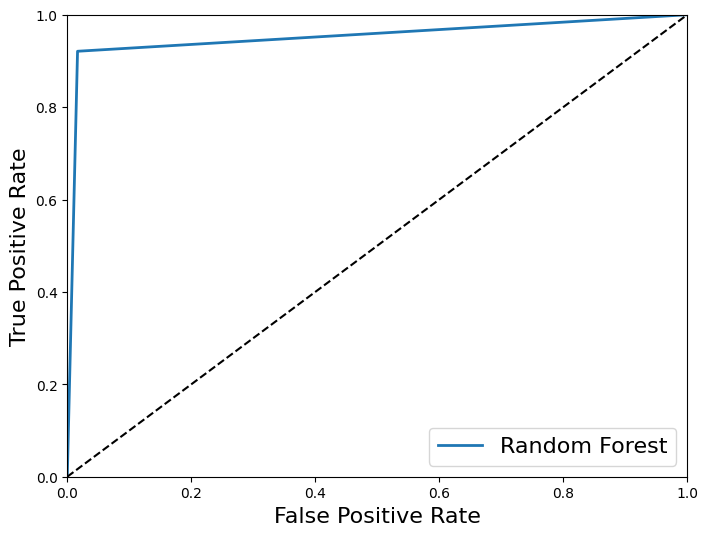

0.9521771177385605

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

scores = cross_val_score(tree_class, X_useful_train, y_train_useful_encoded,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_predict = cross_val_predict(tree_class, X_useful_train, y_train_useful_encoded, cv=10, method='predict_proba')

display_scores(tree_rmse_scores)
tree_scores = tree_predict[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_useful_encoded,tree_scores)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_forest, tpr_forest, "Decision Tree")
plt.legend(loc="lower right", fontsize=16)
plt.show()

roc_auc_score(y_train_useful_encoded, tree_scores)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

# Initialiser le modèle RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraîner le modèle sur l'ensemble d'entraînement
rf.fit(X_useful_train, Y_useful_train)

# Évaluer les performances du modèle sur l'ensemble de test
y_pred = rf.predict(X_useful_test)
accuracy = accuracy_score(y_useful_test, y_pred)
print(f"Accuracy: {accuracy}")

# Display the cross validation prediction
y_test_predict = cross_val_predict(tree_class, X_useful_test, y_test_useful_encoded, cv=10, method='predict_proba')
y_test_scores = tree_predict[:,1]

# Display the ROC curve
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test_useful_encoded,tree_scores)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

# Display the ROC AUC score
roc_auc_score(y_train_useful_encoded, tree_scores)